# Import

In [22]:
import time
import gym_2048
from tensorforce import Agent, Environment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
%load_ext tensorboard

# import pour visualiser les parties
from IPython.display import display, HTML
from IPython.display import clear_output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Plotting utils

In [2]:
# fonction pour ranger en ordre croissant un dico dans le but de le plotter avec plt
def sort_dico(dico):
    dico_sorted={}
    for k,v in dict(sorted(dico.items())).items():
        k_str = str(k)
        dico_sorted[k_str] = v

    return dico_sorted

In [3]:
# fonction pour plotter la distribution des scores et des max tiles
# à utiliser avec la fonction de test 'test_agent' et ce qu'elle retourne
# dico_sorted = sort_dico(dico_max_tiles_distribution)
# rewards = liste_score

def plot_metrics(dico_sorted,rewards):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Max tile distribution')
    plt.bar(*zip(*dico_sorted.items()))

    plt.subplot(1, 2, 2)
    plt.title('Score distribution')
    sns.histplot(rewards, kde=True)

    print(f'Mean score over the test: {np.mean(rewards)}')
    print(f'Median score over the test: {np.median(rewards)}')
    print(f'Std score over the test: {np.std(rewards)}')
    print(f'Max tile over the test: {max([int(bins) for bins in dico_sorted.keys()])}')

In [23]:
# fonction pour imprimer les parties avec un visuel proche de celui du jeu 2048

def pretty_print(layout):
    from math import log2
    def parse_color(cell_value):
        if cell_value>0:
            colors = ["#EEE4DA", "#ECE0CA", "#F2B179", "#F59565", "#F57C5F", "#F65D3B", "#EDCE71", "#EDCC63", "#EDC850", "#EDC53F", "#EEC22E", "#3E3933"]
            return colors[int(log2(cell_value))-1]
        else:
            return "#CDC0B4"

    def cell_block(cell_value):
        return '''
        <td style=font-size:{}px;background-color:#BBADA0;text-align:center;width:100%>
            <div style=color:#776E65;background-color:{};width:60px;height:60px;margin:auto;display:flex;align-items:center;justify-content:center;border-radius:6px;font-family:serif;font-size:medium><strong>{}</strong>
            </div>
        </td>'''.format('1', parse_color(cell_value), cell_value if cell_value>0 else '')
    return '''
            <div style=background-color:#BBADA0;width:300px;height:300px>
            <table style=width:100%;height:100%>
              <tr>
                {}
                </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
            </table>
            </div>
            '''.format('\n'.join([cell_block(val) for val in layout[0,:]]),
                      '\n'.join([cell_block(val) for val in layout[1,:]]),
                       '\n'.join([cell_block(val) for val in layout[2,:]]),
                       '\n'.join([cell_block(val) for val in layout[3,:]]))


# Useful code snippets

Render "beautiful" 2048 grid:

`plt.imshow(environment._environment.environment.render(mode="rgb_array"))`

Illegal move reward:

`environment._environment.environment.set_illegal_move_reward(-10)`

Log2 reward:

`log2_reward = reward if reward <= 0 else np.log2(reward)`

Show TensorBoard graphs:

`%tensorboard --logdir summaries` (with parameter `summarizer=dict(directory='summaries')` in the `Agent.create()` method)

# Training functions

In [4]:
def create_agent_and_env(env_params, agent_params):
    agent_name = agent_params["agent_name"]
    agent_params_ = dict(agent_params)
    del agent_params_["agent_name"] # A TensorForce agent doesn't take name as a parameter
    
    
    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
    )

    # create an agent
    agent = Agent.create(
        agent = 'dqn',
        environment = environment,
        **agent_params_,
        summarizer = dict(directory=f'training_logs/{agent_params["agent_name"]}/TensorBoard',
                          summaries=["episode-reward"])
    )
    return (environment, agent)

In [5]:
def train_agent(environment, agent, num_episodes, print_freq, agent_name, training_round = 0):

    # instantiate lists to record global training metrics
    max_tiles = []
    scores = []
    updates = []
    valid_moves = []
    run_time = []
    start_training_time = time.time()

    for episode in range(num_episodes):
        state = environment.reset()
        terminal = False

        #Checking metrics while training
        state_freeze = state.copy()
        num_updates = 0
        num_moves = 0
        invalid_moves = 0
        start_episode_time = time.time()

        while not terminal:
            #Core
            action = agent.act(states=dict(state=state,  action_mask=environment._environment.environment.get_invalid_moves()))
            state, terminal, reward = environment.execute(actions=action)
            log2_reward = reward if reward <= 0 else np.log2(reward)
            num_updates += agent.observe(terminal=terminal, reward=log2_reward)

            #Number of moves
            num_moves += 1

            #Number of invalid moves
            if (state == state_freeze).all():
                invalid_moves += 1
            state_freeze = state.copy()

        # Storing score and max tile
        max_tiles.append(environment._environment.environment.Matrix.max())
        scores.append(environment._environment.environment.score)
        updates.append(num_updates)
        valid_moves.append(num_moves)
        run_time.append(round(time.time() - start_episode_time,2))

        if episode % print_freq == 0:
            print('Episode {}: score = {}, terminal = {}, updates={}, max_tile={}, valid_moves={}, invalid_moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, num_updates, max_tiles[-1], num_moves-invalid_moves, invalid_moves, round(time.time() - start_episode_time,2)))
    
    # Saving agent
    agent.save(f'training_logs/{agent_name}/agent_round{training_round}', filename=agent_name)
    
    # Saving metrics
    metrics_dict = {
        'max_tiles': max_tiles
        , 'scores': scores
        , 'updates': updates
        , 'valid_moves': valid_moves
        , 'run_time' : run_time
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_path = f'training_logs/{agent_name}/metrics_round{training_round}_({episode}episodes).csv'
    metrics_df.to_csv(metrics_path)
    
    return (metrics_df, agent)

In [6]:
def save_params(agent_params, env_params):
    all_params = {
        "agent_params": agent_params,
        "env_params": env_params,
    }
    
    directory_path = f'training_logs/{agent_params["agent_name"]}'
    !mkdir -p $directory_path
    
    file_name = f'training_logs/{agent_params["agent_name"]}/params.json'
    with open(file_name, 'w') as fp:
            json.dump(all_params, fp)

# Training

In [7]:
agent_params = {
    "agent_name": input("Agent name (only letter, digits and underscores). NO SPACE: "),
    'batch_size': 16,
    'update_frequency': 4,
    'learning_rate': 0.0001,
    'discount': 0.99,
    'memory': 10000,
    'exploration': 0.05,
    'target_sync_frequency': 4,
    'horizon': 1
}

env_params = {
    'max_episode_timesteps': 10000
}

if " " in agent_params["agent_name"]:
    print ("NO SPACE")
    agent_params = 0

Agent name (only letter, digits and underscores). NO SPACE: APG_test_0


In [8]:
# Saving params to .json in training_logs folder
save_params(agent_params, env_params)

In [9]:
# Creating agent and environnement
environment, agent = create_agent_and_env(env_params, agent_params)

In [60]:
# Train ! Increment training round for several round of trainings

training_params = {
    "num_episodes": 5_000,
    "print_freq": 100,
    "agent_name": agent_params["agent_name"],
    "training_round": 3
}

metrics_df, agent = train_agent(environment, agent, **training_params)

Episode 0: score = 11208.0, terminal = 1, updates=161, max_tile=1024, valid_moves=646, invalid_moves=0, seconds=3.52
Episode 100: score = 3448.0, terminal = 1, updates=71, max_tile=256, valid_moves=287, invalid_moves=0, seconds=1.21
Episode 200: score = 3404.0, terminal = 1, updates=71, max_tile=256, valid_moves=286, invalid_moves=0, seconds=1.2
Episode 300: score = 5408.0, terminal = 1, updates=92, max_tile=512, valid_moves=370, invalid_moves=0, seconds=1.57
Episode 400: score = 11424.0, terminal = 1, updates=168, max_tile=1024, valid_moves=673, invalid_moves=0, seconds=2.84
Episode 500: score = 3564.0, terminal = 1, updates=74, max_tile=256, valid_moves=296, invalid_moves=0, seconds=1.25
Episode 600: score = 3668.0, terminal = 1, updates=75, max_tile=256, valid_moves=300, invalid_moves=0, seconds=1.28
Episode 700: score = 1984.0, terminal = 1, updates=50, max_tile=128, valid_moves=200, invalid_moves=0, seconds=0.85
Episode 800: score = 3128.0, terminal = 1, updates=64, max_tile=256, 

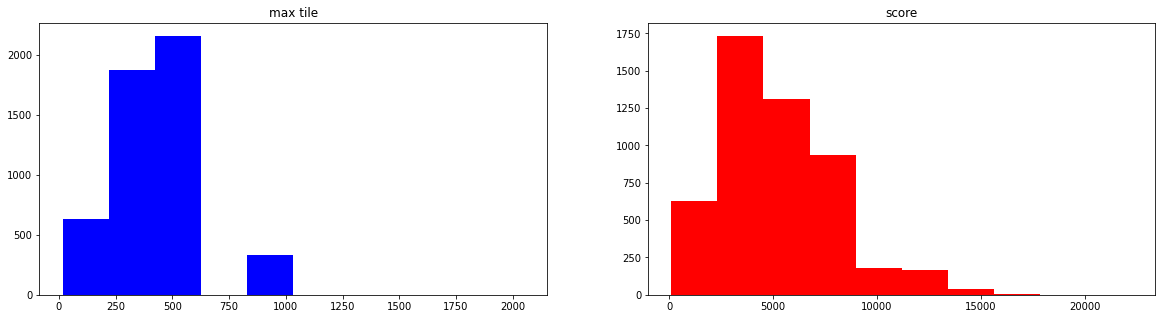

In [61]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(metrics_df.max_tiles, color = 'b')
ax1.set_title('max tile')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(metrics_df.scores, color = 'r')
ax2.set_title('score');

In [51]:
%tensorboard --logdir "training_logs"

# Testing

In [43]:
# Evaluate for n episodes
def test_agent(agent,n_episode,visualization,pause=0.01):
    #definir l'env
    environment = Environment.create(environment = 'gym', level = '2048-v0', 
    max_episode_timesteps = 10_000
    )
    n_episode = n_episode
    #dictionnaire pour obtenir la distribution des max tiles de chaque episode
    dico_max_tiles_distribution = {}
    # liste des score par episode
    liste_score=[]
    # dictionnaire pour récupérer la meilleure et la pire partie du test
    dico_best_worst_episode = {'Worst':[],'Best':[], 'Episode # Worst':[], 'Episode # Best':[]}

    for episode in range(n_episode):
        sum_rewards = 0.0
        states = environment.reset()
        list_states=[]
        internals = agent.initial_internals()
        terminal = False
        if visualization == 'yes':
            clear_output(wait=True)
            print(f'Game #: {episode+1}')
            time.sleep(3)

        while not terminal:
            actions, internals = agent.act(
                states= {
                    "state":states,
                    "action_mask":environment._environment.environment.get_invalid_moves()},
                internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            matrix = environment._environment.environment.Matrix
            list_states.append(matrix.copy())
            sum_rewards += reward
            if visualization == 'yes':
                clear_output(wait=True)
                display(HTML(pretty_print(matrix)))
                time.sleep(pause)

        liste_score.append(sum_rewards)

        if sum_rewards >= max(liste_score):
            dico_best_worst_episode['Best'] = list_states
            dico_best_worst_episode['Episode # Best'] = episode
        elif sum_rewards <= min(liste_score):
            dico_best_worst_episode['Worst'] = list_states
            dico_best_worst_episode['Episode # Worst'] = episode

        dico_max_tiles_distribution.setdefault(environment._environment.environment.Matrix.max(),0)
        dico_max_tiles_distribution[environment._environment.environment.Matrix.max()] += 1
        if visualization == 'yes':
            if environment._environment.environment.Matrix.max() < 2048:
                print(f"My final score is {environment._environment.environment.score} with a max tile at {environment._environment.environment.Matrix.max()}. Let's try again!")
            else:
                print(f"My final score is {environment._environment.environment.score} with a max tile at {environment._environment.environment.Matrix.max()}. I mastered this game!")
            time.sleep(3)
        
    return dico_best_worst_episode, liste_score, dico_max_tiles_distribution


In [70]:
results = test_agent(agent, 10, 'yes',1)

32,128,512,16
16,32,8,4
8,4,4,
4,4,,


KeyboardInterrupt: 

Mean score over the test: 5260.88
Median score over the test: 3624.0
Std score over the test: 3925.434379224801
Max tile over the test: 1024


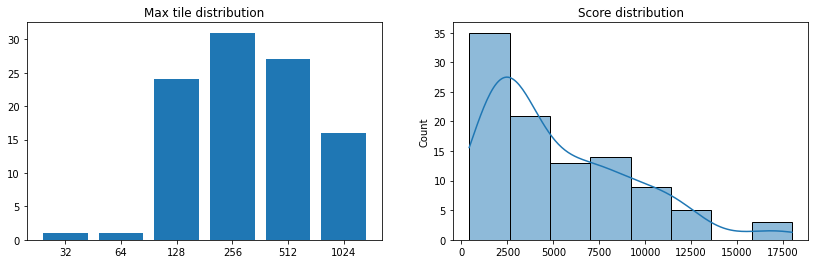

In [68]:
plot_metrics(sort_dico(results[2]), results[1])